In [17]:
import os, sys, time, pickle
from pathlib import Path
from collections import Counter
from IPython.display import Audio

PROJECT_DIR = Path(sys.path[0])/".."
DATA_DIR = PROJECT_DIR/"data"
SRC_DIR = PROJECT_DIR/"src"
DEPS_DIR = PROJECT_DIR/"deps"

sys.path.append(str(SRC_DIR))
sys.path.append(str(DEPS_DIR))

%pylab inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload 
%autoreload 2

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from fairseq_wav2vec import Wav2Vec2Config, Wav2Vec2Model
import pandas as pd

import lightning.pytorch as pl

torch.set_float32_matmul_precision("medium")

from mugen_train import (
    musicDataset, IDX_to_GENRE, GENRE_TO_IDX, 
    get_music_data_loaders, GenreClassifier, 
#     train_genre_predict, validation_genre_predict,
    GenreEncoder,
    get_num_params)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print(pl.__version__) 

2.0.0


In [3]:
feature_size = 128
n_genres = 50
top50_genre_samples_df = pd.read_csv("/n1Tb/sc_mp3_top50_genre_samples.tsv_gz", compression='gzip', sep='\t')

train_loader, valid_loader = get_music_data_loaders(top50_genre_samples_df, cut=8e4)

In [4]:
precision = 16

encoder = Wav2Vec2Model(Wav2Vec2Config)

t_specs = {
#     "d_model": 128, 
    "dim_feedforward": 64, 
    "num_decoder_layers": 0,
    "num_encoder_layers": 0,
    "nhead": 1,
}
decoder = GenreClassifier(n_genres, feature_size, t_specs=t_specs, use_transformer=False)
# genre_loss_model = GenreLoss(n_genres, feature_size, genre_classifier)

print(f"wav2vec-model n_params: {get_num_params(encoder):,d}")
print(f"genre_classifier n_params: {get_num_params(decoder):,d}")

# optimizer = torch.optim.Adam(model.parameters(), lr=0.05, betas=(0.9,0.98), eps=1e-06, weight_decay=0.01, fused=True)
#optimizer = torch.optim.Adam(genre_classifier.parameters(), lr=0.005, betas=(0.9,0.98), eps=1e-06, weight_decay=0.01, fused=True)

wav2vec-model n_params: 95,356,288
genre_classifier n_params: 5,100


In [14]:
genre_predictor = GenreEncoder(encoder, decoder)

# torch.multiprocessing.set_start_method('spawn')

trainer = pl.Trainer(
    limit_train_batches=1000, 
    max_epochs=1, 
    accelerator="gpu", 
    devices=1,
#     strategy='ddp_notebook',     
#     precision='16-mixed'
#     precision=16, 
#     devices=2, 
)

# trainer.fit(model=genre_predictor, train_dataloaders=train_loader)

INFO: GPU available: True (cuda), used: True
2023-03-28 22:52:04 | INFO | lightning.pytorch.utilities.rank_zero | GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2023-03-28 22:52:04 | INFO | lightning.pytorch.utilities.rank_zero | TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2023-03-28 22:52:04 | INFO | lightning.pytorch.utilities.rank_zero | IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2023-03-28 22:52:04 | INFO | lightning.pytorch.utilities.rank_zero | HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
2023-03-28 22:53:46 | INFO | lightning.pytorch.accelerators.cuda | LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
2023-03-28 22:54:28 | INFO | lightning.pytorch.utilities.rank_zero | `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0630957344480193
2023-03-28 22:54:28 | INFO | lightning.pytorch.tuner.lr_finder | Learning rate set to 0.0630957344480193
INFO: Restoring states from the checkpoint path at /home/keld/projects/music_gen/mugen_ml/nbs/.lr_find_664d59da-116d-48f5-9286-b2ce6152eb25.ckpt
2023-03-28 22:54:28 | INFO | lightning.pytorch.utilities.rank_zero | Restoring states from the checkpoint path at /home/keld/projects/music_gen/mugen_ml/nbs/.lr_find_664d59da-116d-48f5-9286-b2ce6152eb25.ckpt
INFO: Restored all states from the checkpoint at /home/keld/projects/music_gen/mugen_ml/nbs/.lr_find_664d59da-116d-48f5-9286-b2ce6152eb25.ckpt
2023-03-28 22:54:29 | INFO | lightning.pytorch.utilities.rank_zero | Restored all states from the checkpoint at /home/keld/projects/music_gen/mugen_ml/nbs/.lr_find_664d59da-116d-48f5

In [20]:
out_lr_finder.results.keys()

dict_keys(['lr', 'loss'])

### Learning rate finder

In [35]:
def get_lr(trainer, model, train_loader, plot=False):
    tuner = pl.tuner.tuning.Tuner(trainer)
    out_lr_finder = tuner.lr_find(model=model, train_dataloaders=train_loader)

    lrf_lr = out_lr_finder.results["lr"]
    lrf_loss = out_lr_finder.results["loss"]
    opt_idx = out_lr_finder._optimal_idx
    if plot:
        plt.plot(lrf_lr, lrf_loss);
        plt.plot(lrf_lr[opt_idx], lrf_loss[opt_idx], "x", label="optimum");
        plt.legend()

        plt.xscale("log");
    print(f"Optimal lr: {lrf_lr[opt_idx]}")        
    return lrf_lr[opt_idx]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
2023-03-28 23:05:27 | INFO | lightning.pytorch.accelerators.cuda | LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
2023-03-28 23:06:09 | INFO | lightning.pytorch.utilities.rank_zero | `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0630957344480193
2023-03-28 23:06:09 | INFO | lightning.pytorch.tuner.lr_finder | Learning rate set to 0.0630957344480193
INFO: Restoring states from the checkpoint path at /home/keld/projects/music_gen/mugen_ml/nbs/.lr_find_d1c4077c-6cd5-4b8e-982e-47accb167405.ckpt
2023-03-28 23:06:09 | INFO | lightning.pytorch.utilities.rank_zero | Restoring states from the checkpoint path at /home/keld/projects/music_gen/mugen_ml/nbs/.lr_find_d1c4077c-6cd5-4b8e-982e-47accb167405.ckpt
INFO: Restored all states from the checkpoint at /home/keld/projects/music_gen/mugen_ml/nbs/.lr_find_d1c4077c-6cd5-4b8e-982e-47accb167405.ckpt
2023-03-28 23:06:09 | INFO | lightning.pytorch.utilities.rank_zero | Restored all states from the checkpoint at /home/keld/projects/music_gen/mugen_ml/nbs/.lr_find_d1c4077c-6cd5-4b8e

Optimal lr: 0.0630957344480193


0.0630957344480193

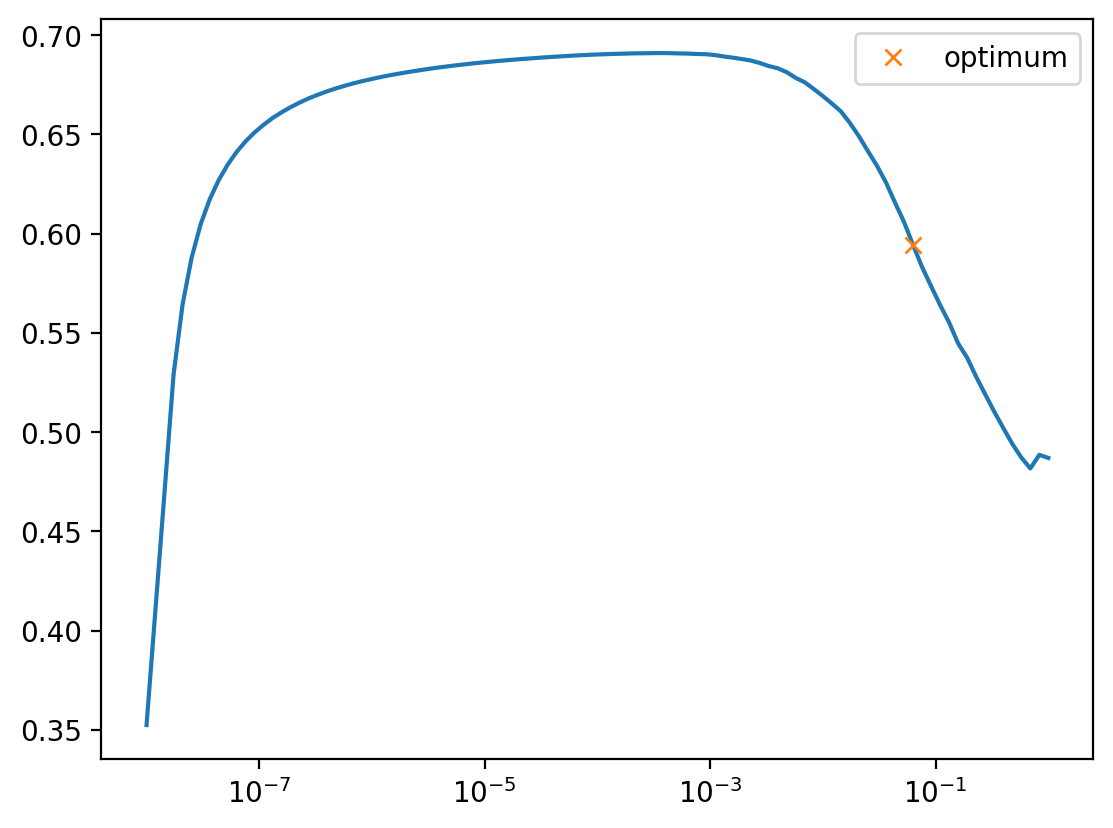

In [36]:
get_lr(trainer, genre_predictor, train_loader, plot=True)

optimal lr: 0.0630957344480193


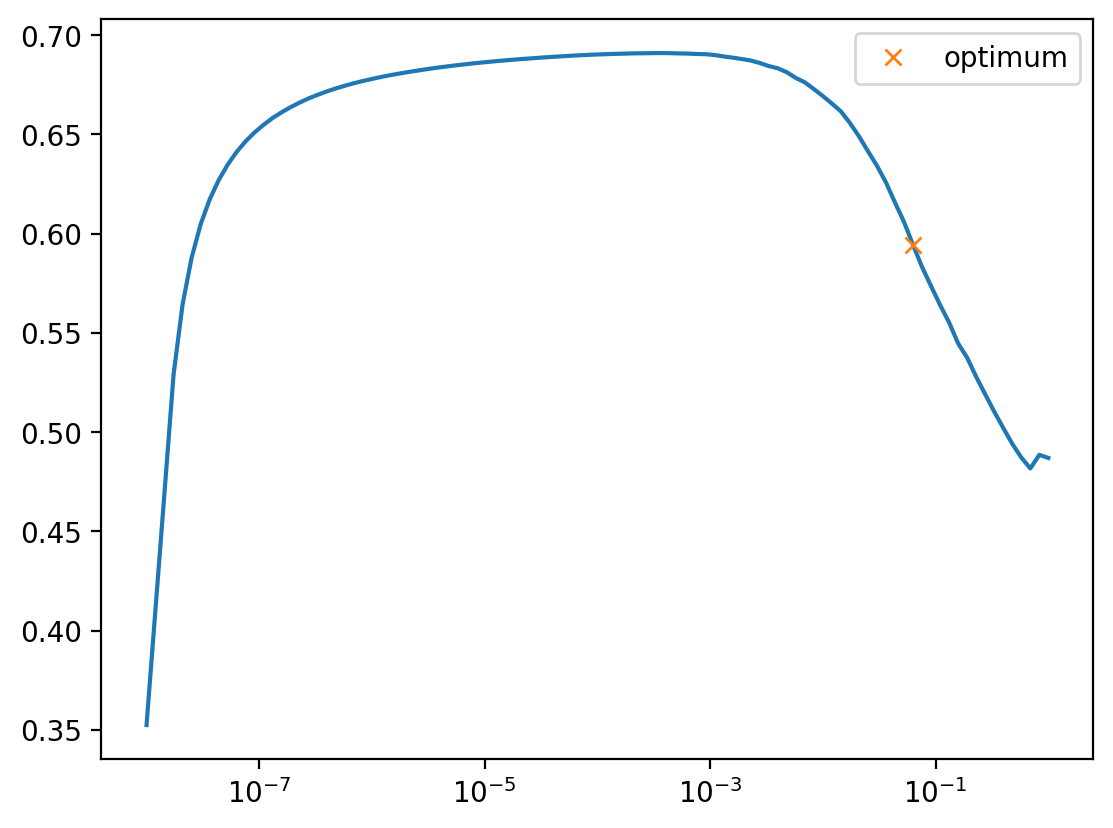

In [34]:
lrf_lr = out_lr_finder.results["lr"]
lrf_loss = out_lr_finder.results["loss"]
opt_idx = out_lr_finder._optimal_idx

plt.plot(lrf_lr, lrf_loss);
plt.plot(lrf_lr[opt_idx], lrf_loss[opt_idx], "x", label="optimum");
plt.legend()

plt.xscale("log");
print(f"Optimal lr: {lrf_lr[opt_idx]}")

In [25]:
out_lr_finder.__dict__.keys()

dict_keys(['mode', 'lr_min', 'lr_max', 'num_training', 'results', '_total_batch_idx', '_optimal_idx'])

In [28]:
out_lr_finder.mode

'exponential'

In [26]:
out_lr_finder._optimal_idx

84

In [12]:
genre_predictor.lr

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 genre_predictor.lr                                                                           │
│   2                                                                                              │
│                                                                                                  │
│ /home/keld/miniconda3/envs/mugen_ml/lib/python3.9/site-packages/torch/nn/modules/module.py:1269  │
│ in __getattr__                                                                                   │
│                                                                                                  │
│   1266 │   │   │   modules = self.__dict__['_modules']                                           │
│   1267 │   │   │   if name in modules:                                                           │
│   1268 │   │   │   │   return modules[name]                                                      │
│ ❱ 1269 │   │   raise AttributeError("'{}' object has no attribute '{}'".format(                  │
│   1270 │   │   │   type(self).__name__, name))                                                   │
│   1271 │                                                                                         │
│   1272 │   def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'GenreEncoder' object has no attribute 'lr'

In [5]:
%debug

> /home/keld/miniconda3/envs/mugen_ml/lib/python3.9/site-packages/fairseq/utils.py(744)index_put()
    742         tensor = torch.mul(tensor, ~indices) + torch.mul(value, indices)
    743     else:
--> 744         tensor[indices] = value
    745     return tensor
    746 



ipdb>  up


> /home/keld/projects/music_gen/mugen_ml/src/fairseq_wav2vec.py(457)apply_mask()
    455                 )
    456                 mask_indices = torch.from_numpy(mask_indices).to(x.device)
--> 457             x = index_put(x, mask_indices, self.mask_emb)
    458         else:
    459             mask_indices = None



ipdb>  q


In [ ]:
trainer = pl.Trainer(limit_train_batches=100, max_epochs=1)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)


In [4]:
#train_genre_predict(model, optimizer, data_loader, debug=False)

In [5]:
train_loses = []
val_loses = []
for epoch in range(3):
    train_loss = train_genre_predict(model, genre_classifier, optimizer, train_loader)
    val_loss = validation_genre_predict(model, genre_classifier, valid_loader)
    print(f"{epoch:03d} train_loss: {train_loss:0.4f} val_loss: {val_loss:0.4f}")
    train_loses.append(train_loss)
    val_loses.append(val_loss)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.24it/s]


000 train_loss: 0.2316 val_loss: 0.2222


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.49it/s]


001 train_loss: 0.2308 val_loss: 0.2231


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.38it/s]

002 train_loss: 0.2311 val_loss: 0.2151


In [7]:
import lightning.pytorch as pl


2023-03-27 19:46:10 | INFO | torch.distributed.nn.jit.instantiator | Created a temporary directory at /tmp/tmpfqa29ime
2023-03-27 19:46:10 | INFO | torch.distributed.nn.jit.instantiator | Writing /tmp/tmpfqa29ime/_remote_module_non_scriptable.py


In [ ]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
autoencoder = LitAutoEncoder(encoder, decoder)

In [4]:
debug = False
data_loader = train_loader

model.train()
running_loss = 0.0
losses = []
for i, (batch, genres) in tqdm(enumerate(data_loader, 0), total=len(data_loader), disable=debug):
    optimizer.zero_grad()
    outputs = model(batch)
    
    x = outputs["x"]
    
    # discard where there is inf values 
    num_inf = torch.sum(torch.isinf(x))
    if num_inf:
        ignore_samples = torch.where(x.isinf())[1].unique()
        filter_samples = [i not in ignore_samples for i in range(x.shape[1])]
        x = x[:, filter_samples, :]
        genres = [genre for i, genre in enumerate(genres) if i not in ignore_samples]
        if debug:
            print(f"num_inf in output of model {num_inf}")        
            print(f"Num of ignored samples: {len(ignore_samples)}") 
            
    genre_props = genre_classifier(x)
    min_max_prop = genre_props.min().to("cpu").item(), genre_props.max().to("cpu").item() 
    if np.isnan(min_max_prop[0]) or np.isnan(min_max_prop[1]):
        print("np.isnan(min_max_prop[0]) or np.isnan(min_max_prop[1])")
        break
    genre_loss = torch.nn.BCELoss()(genre_props, get_batch_genre_one_hot(genres, n_genres, "cuda"))

    wav2vec_features_pen = outputs["features_pen"]
    
    loss = genre_loss #+ 0.1 * wav2vec_features_pen
    loss_item = loss.to("cpu").item() 
#     if debug:
#         print("min_max_prop", min_max_prop)
#         print("losses", loss_item, genre_loss.to("cpu").item(), wav2vec_features_pen.to("cpu").item())    

    loss.backward()
    optimizer.step()
    running_loss += loss_item
    losses.append(loss_item)

#     out_is_inf = torch.isinf(x).any().item()
#     if out_is_inf:
#         inf_values = torch.isinf(x).sum() 
#         print(f"{inf_values} inf values in output")
#         break    

#     for name, param in genre_classifier.named_parameters():
#         has_nan = torch.isnan(param).any()
#         has_inf = torch.isinf(param).any()

#         if has_nan or has_inf:
#             print(f"genre_classifier {name} has_nan {has_nan} has_inf {has_inf}.")
#             break        
        
#     for name, param in model.named_parameters():
#         has_nan = torch.isnan(param).any()
#         has_inf = torch.isinf(param).any()

#         if has_nan or has_inf:
#             print(f"Parameter {name} has_nan {has_nan} has_inf {has_inf}.")
#             break

#     if has_nan or has_inf:
#         print("has_nan or has_inf")
#         break
    
return running_loss / len(data_loader)

100%|███████████████████████████████████████| 4167/4167 [49:59<00:00,  1.39it/s]


In [5]:
loss

tensor(0.1988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
data_loader = train_loader

model.train()
running_loss = 0.0
losses = []
for i, (batch, genres) in tqdm(enumerate(data_loader, 0), total=len(data_loader), disable=True):
    pass

In [4]:
for i, (batch, genres) in tqdm(enumerate(data_loader, 0), total=len(data_loader), disable=True):
    pass


NameError: name 'data_loader' is not defined

In [70]:
# Audio(batch[12].to("cpu").detach().numpy(), rate=44100, autoplay=True)

In [12]:
# from matplotlib import colors
# cmap = colors.ListedColormap(['red', 'blue', 'green', 'purple',])
# bounds = [-2,0,2]
# norm = colors.BoundaryNorm(bounds, cmap.N)

# fig, ax = plt.subplots()
# ax.imshow(outputs["x"][:, 5, :].to("cpu").detach().numpy(), cmap=cmap, norm=norm);


In [ ]:
genre_props

In [21]:
for name, param in genre_classifier.named_parameters():
    print(param)
    min_max = (torch.min(param).to("cpu").detach().item(), torch.max(param).to("cpu").detach().item())
    print(f"min: {min_max[0]:,.3f} max: {min_max[1]:,.3f}")


Parameter containing:
tensor([[ 1.5653e-02,  1.0166e-02,  1.3567e-02,  ..., -1.4283e-03,
         -3.4696e-05, -1.8214e-03],
        [ 1.4348e-02,  1.4168e-02,  1.3006e-02,  ..., -2.0981e-04,
          1.5393e-03, -1.8361e-03],
        [ 7.3778e-03,  1.2378e-02,  8.1439e-03,  ...,  6.5706e-04,
         -1.8284e-03,  7.1113e-04],
        ...,
        [ 1.4650e-02,  1.1347e-02,  1.1165e-02,  ...,  2.6091e-04,
         -2.0520e-04,  6.1813e-05],
        [ 1.1922e-02,  1.2531e-02,  1.1692e-02,  ...,  9.5847e-04,
         -1.7996e-04, -9.5097e-05],
        [ 1.3669e-02,  1.0285e-02,  1.3568e-02,  ..., -2.1436e-04,
          3.3145e-04,  6.9002e-04]], device='cuda:0', requires_grad=True)
min: -0.002 max: 0.022
Parameter containing:
tensor([-0.2848, -0.3124, -0.2516, -0.2560, -0.3290, -0.3366, -0.3669, -0.2745,
        -0.3922, -0.3738, -0.3439, -0.3426, -0.3462, -0.3399, -0.4030, -0.2628,
        -0.2674, -0.3926, -0.3747, -0.2488, -0.3014, -0.3583, -0.2426, -0.2944,
        -0.2869, -0.3600

In [83]:
music_cnn = MusicCNN(50)

In [17]:
param.size()

torch.Size([384])

In [ ]:
for name, param in genre_classifier.named_parameters():

### Test 2 -- with small update

In [4]:
train_loses = []
val_loses = []
for epoch in range(3):
    train_loss = train(model, optimizer, train_loader)
    val_loss = validation(model, valid_loader)
    print(f"{epoch:03d} train_loss: {train_loss:0.4f} val_loss: {val_loss:0.4f}")
    train_loses.append(train_loss)
    val_loses.append(val_loss)

100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.05it/s]


000 train_loss: 0.0000 val_loss: 0.0000


100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.10it/s]


001 train_loss: 0.0000 val_loss: 0.0000


100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.10it/s]

002 train_loss: 0.0000 val_loss: 0.0000


In [ ]:
plt.plot(train_loses, label="train_loses");
plt.plot(val_loses, label="val_loses");
plt.legend();

### Test 1 -- diverging

In [5]:
train_loses = []
val_loses = []
for epoch in range(5):
    train_loss = train(model, optimizer, train_loader)
    val_loss = validation(model, valid_loader)
    print(f"{epoch:03d} train_loss: {train_loss:0.4f} val_loss: {val_loss:0.4f}")
    train_loses.append(train_loss)
    val_loses.append(val_loss)

100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.10it/s]


000 train_loss: 0.0000 val_loss: 0.0000


100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.11it/s]


001 train_loss: 0.0000 val_loss: 0.0000


100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.11it/s]


002 train_loss: 0.0000 val_loss: 0.0000


100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.09it/s]


003 train_loss: 0.0000 val_loss: 0.0000


100%|████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  4.05it/s]

004 train_loss: 0.0000 val_loss: 0.0000


In [ ]:
%debug

#### Scratchpad

In [49]:
for epoch in range(10):
    train_loss = train(model, optimizer, criterion, train_loader)
    print(f"Epoch {epoch+1}, train loss: {train_loss:.3f}")


In [66]:
for i, batch in enumerate(top50_dataloader):
    break

In [18]:
out = model.forward(sample_bs)

In [160]:
sample_bs.shape

torch.Size([32, 120000])

In [144]:

d.shape

torch.Size([2, 273024])

In [4]:
model.eval()
running_loss = 0.0
for i, (batch, genres) in tqdm(enumerate(valid_loader, 0), total=len(valid_loader)):
    outputs = model(batch)
    break

  0%|                                                                     | 0/17 [00:02<?, ?it/s]


In [18]:
outputs['x'].shape

torch.Size([101, 12, 120])

In [10]:
batch

<function __main__.music_collate_fn_wrap.<locals>.music_collate_fn(x)>